compare tasks (cookieTheft, picnicScene, journaling) to see which task's feature set best predicts a target score

uses the intersection of subjects (data available for full model, for all three tasks)

new: bootstrapping for CIs and mean out-of-fold R^2

In [1]:
# setup
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.patheffects as pe
from pandas.api.types import CategoricalDtype

# add project root
sys.path.append("/Users/gilanorup/Desktop/Studium/MSc/MA/code/masters_thesis_gn/src")

from config.constants import GIT_DIRECTORY
from config.feature_sets import get_linguistic_features, get_acoustic_features
from regression.regression_helpers import stratified_cross_validation
from regression.evaluation_helpers import (
    format_title, load_task_dataframe, get_model_feature_list, complete_subjects, subjects_with_all_features_and_scores, _normalize_oof_df, bootstrap_summary_from_oof,
    compare_models_bootstrap, plot_bootstrap_violin
)

# define target score
target = "SemanticFluencyScore"
tasks = ["cookieTheft", "picnicScene", "journaling"]

# load scores & demographic data
scores_path = os.path.join(GIT_DIRECTORY, "data/language_scores_all_subjects.csv")
demographics_path = os.path.join(GIT_DIRECTORY, "data/demographics_data.csv")
scores = pd.read_csv(scores_path)
demographics = pd.read_csv(demographics_path)

scores_all = pd.read_csv(scores_path)
scores = scores_all.copy()
scores = scores.dropna(subset=[target])

# save path
save_path = os.path.join(GIT_DIRECTORY, "results", "regression", "model_comparison", "filtered", "tasks")
os.makedirs(save_path, exist_ok=True)

In [2]:
# prepare demographics
for col in ["Gender","Education","Country"]:
    demographics[col] = demographics[col].astype("string").str.lower().str.strip()
demographics["Socioeconomic"] = pd.to_numeric(demographics["Socioeconomic"], errors="coerce")

demographics["Gender"] = demographics["Gender"].map({"f": 0, "m": 1})
education_map = {
    "less_than_highschool": 1,
    "high_school": 2,
    "vocational": 3,
    "bachelor": 4,
    "master": 5,
    "phd": 6,
    "no_answer": np.nan
}
demographics["Education"] = demographics["Education"].map(education_map)
demographics["Education_group_code"] = demographics["Education"].map({
    1: 0, # low
    2: 1, 3: 1, # medium
    4: 2, 5: 2, 6: 2 # high
})
demographics["Country"] = demographics["Country"].map({"uk": 0, "usa": 1})
demographics.drop(columns=["Language"], inplace=True, errors="ignore")

In [3]:
# define feature sets
linguistic_features = get_linguistic_features()
acoustic_features = get_acoustic_features()

# set up models (select available features inside loop later)
demographic_cols = ["Age", "Gender", "Education_group_code", "Country", "Socioeconomic"]

model_configs = {
    "baseline": [],
    "demographics": demographic_cols,
    "linguistic": sorted(list(linguistic_features)),
    "acoustic": sorted(list(acoustic_features)),
    "linguistic+acoustic": sorted(list(linguistic_features | acoustic_features)),
    "full": sorted(list(linguistic_features | acoustic_features)) + demographic_cols
}

model_order = ["baseline", "demographics", "linguistic", "acoustic", "linguistic+acoustic", "full"]
task_order = ["cookieTheft", "picnicScene", "journaling"]


In [4]:
# load dataframes for tasks
task_dfs = {t: load_task_dataframe(t, target, scores, demographics) for t in tasks}

# compute intersection of subjects -> one fixed subject-set used for all analyses

# get full-model existing features for each task
full_requested = model_configs["full"]
full_cols_by_task = {t: get_model_feature_list(task_dfs[t].columns, full_requested, target) for t in tasks}

# get Subject_IDs that have complete data for all three tasks
subject_sets_full = [complete_subjects(task_dfs[t], full_cols_by_task[t], target) for t in tasks]
full_subjects = set.intersection(*subject_sets_full)
print(f"intersection of subjects for full model across all tasks after exclusions: N={len(full_subjects)}")

# save the list of Subject_IDs
full_list_path = os.path.join(save_path, f"{target}_full_subjects.csv")
pd.Series(sorted(full_subjects), name="Subject_ID").to_csv(full_list_path, index=False)

intersection of subjects for full model across all tasks after exclusions: N=970


In [5]:
# define type of regression
model_type = RandomForestRegressor # LinearRegression or RandomForestRegressor
# for saving later
model_type_name = model_type.__name__
# set parameters
model_params = {"n_estimators": 524, "random_state": 42, "min_samples_leaf": 3, "max_features": "sqrt", "bootstrap": True, "max_depth": 15, "min_samples_split": 5} # None for linear regression, for random forest: GridSearch best params {'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 524}

base_model_type = model_type
base_model_params = model_params

fold_results = []
oof_results = []

# loop over tasks
for t in tasks:
    df_t = task_dfs[t]
    # fixed subject set
    df_t = df_t[df_t["Subject_ID"].isin(full_subjects)].copy()

    for model_name, selected_features in model_configs.items():
        # figure out what features exist for this model & task
        feature_cols = get_model_feature_list(df_t.columns, selected_features, target)

        # baseline via DummyRegressor
        model_type = base_model_type
        params = base_model_params
        if model_name == "baseline":
            model_type = DummyRegressor
            params = {"strategy": "mean"}

        # build model_df
        if model_name == "baseline":
            df_use = df_t.dropna(subset=[target]).copy()
            X = pd.DataFrame(np.ones((len(df_use), 1)), index=df_use.index, columns=["__dummy__"])
            feature_cols_final = ["__dummy__"]
        else:
            # other models using features
            if len(feature_cols) == 0:
                # safety: if a non-baseline model ends up empty
                print(f"skip {t} | {model_name}: no available features.")
                continue

            df_use = df_t.dropna(subset=[target] + feature_cols).copy()
            if len(df_use) == 0:
                print(f"skip {t} | {model_name}: no rows after dropna.")
                continue

            X = df_use[feature_cols]
            feature_cols_final = feature_cols

        if len(df_use) == 0:
            print(f"skip {t} | {model_name}: no rows after filtering.")
            continue

        model_df = pd.concat(
            [df_use[["Subject_ID", "fold"]], X, df_use[target].rename(target)],
            axis=1
        )

        features_used_display = 0 if model_name == "baseline" else len(feature_cols_final)
        print(f"{t} | {model_name} | N={len(model_df)} | features used={features_used_display}")

        # cross-validation
        r2_list, rmse_list, mae_list, all_preds = stratified_cross_validation(
            df=model_df,
            fold_column="fold",
            model_type=model_type,
            model_params=params,
            target_column=target,
            feature_columns=feature_cols_final
        )

        fold_df = pd.DataFrame({
            "task": t,
            "model": model_name,
            "fold": list(range(len(r2_list))),
            "r2": r2_list,
            "rmse": rmse_list,
            "mae": mae_list
        })
        fold_df["target"] = target
        fold_results.append(fold_df)

        # store normalized OOF preds per subject (for pairwise stats)
        all_preds = all_preds.rename(columns={"y_test": "y_true"})
        oof_df = _normalize_oof_df(all_preds, target_col=target)
        oof_df["task"] = t
        oof_df["model"] = model_name
        oof_df["target"] = target
        oof_results.append(oof_df)

df_folds = pd.concat(fold_results, ignore_index=True)
oof_preds = pd.concat(oof_results,   ignore_index=True)

# bootstrap summary
_, bootstrap_summary = bootstrap_summary_from_oof(
    oof_preds,
    group_cols=("target", "task", "model"),
    n_boot=1000,  # or 500 if you prefer
    ci=0.95,
    subject_set=None,
    random_state=42
)

bootstrap_summary.to_csv(
    os.path.join(save_path, f"{target}_bootstrap_summary_{model_type_name}.csv"),
    index=False
)

# summary
oof_summary = (bootstrap_summary[["target","task","model","r2_oof","r2_ci_low","r2_ci_high","n_subjects","n_boot"]]
               .sort_values(["task","model"])
               .reset_index(drop=True))

oof_summary_path = os.path.join(save_path, f"{target}_oof_bootstrap_summary_{model_type_name}.csv")
oof_summary.to_csv(oof_summary_path, index=False)
print("saved OOF summary", oof_summary_path)
print(oof_summary.head())

# summary
summary_rows = []
for (task, model), group in df_folds.groupby(["task", "model"]):
    r2_mean = group["r2"].mean()
    r2_std = group["r2"].std()
    r2_se = r2_std / np.sqrt(len(group))
    r2_ci_low = r2_mean - 1.96 * r2_se
    r2_ci_high = r2_mean + 1.96 * r2_se

    summary_rows.append({
        "task": task,
        "model": model,
        "r2_mean": r2_mean,
        "r2_std": r2_std,
        "r2_se": r2_se,
        "r2_ci_low": r2_ci_low,
        "r2_ci_high": r2_ci_high,
    })

summary_df = pd.DataFrame(summary_rows)

# save results
summary_df.to_csv(os.path.join(save_path, f"{target}_model_task_summary_{model_type_name}.csv"), index=False)
df_folds.to_csv(os.path.join(save_path, f"{target}_task_folds_{model_type_name}.csv"), index=False)


cookieTheft | baseline | N=970 | features used=0
cookieTheft | demographics | N=970 | features used=5
cookieTheft | linguistic | N=970 | features used=38
cookieTheft | acoustic | N=970 | features used=9
cookieTheft | linguistic+acoustic | N=970 | features used=47
cookieTheft | full | N=970 | features used=52
picnicScene | baseline | N=970 | features used=0
picnicScene | demographics | N=970 | features used=5
picnicScene | linguistic | N=970 | features used=36
picnicScene | acoustic | N=970 | features used=9
picnicScene | linguistic+acoustic | N=970 | features used=45
picnicScene | full | N=970 | features used=50
journaling | baseline | N=970 | features used=0
journaling | demographics | N=970 | features used=5
journaling | linguistic | N=970 | features used=36
journaling | acoustic | N=970 | features used=9
journaling | linguistic+acoustic | N=970 | features used=45
journaling | full | N=970 | features used=50
saved OOF summary /Users/gilanorup/Desktop/Studium/MSc/MA/code/masters_thesi

In [6]:
# run pairwise model comparison via subject-level paired bootstrap of R^2 differences per task
pairwise_boot = []
for tname in task_order:
    comp = compare_models_bootstrap(oof_preds, task=tname, target=target, n_boot=1000, random_state=42)
    pairwise_boot.append(comp)

pairwise_boot = pd.concat(pairwise_boot, ignore_index=True)
pairwise_boot = pairwise_boot.sort_values(["task", "p_boot", "model_a", "model_b"])

pairwise_path = os.path.join(save_path, f"{target}_pairwise_bootstrap_diffs_{model_type_name}.csv")
pairwise_boot.to_csv(pairwise_path, index=False)
print(f"saved pairwise bootstrap comparisons {pairwise_path}")
print(pairwise_boot.head(12))

saved pairwise bootstrap comparisons /Users/gilanorup/Desktop/Studium/MSc/MA/code/masters_thesis_gn/results/regression/model_comparison/filtered/tasks/SemanticFluencyScore_pairwise_bootstrap_diffs_RandomForestRegressor.csv
           task                target              model_a  \
13  cookieTheft  SemanticFluencyScore             acoustic   
12  cookieTheft  SemanticFluencyScore             acoustic   
4   cookieTheft  SemanticFluencyScore             baseline   
1   cookieTheft  SemanticFluencyScore             baseline   
3   cookieTheft  SemanticFluencyScore             baseline   
8   cookieTheft  SemanticFluencyScore         demographics   
5   cookieTheft  SemanticFluencyScore         demographics   
7   cookieTheft  SemanticFluencyScore         demographics   
2   cookieTheft  SemanticFluencyScore             baseline   
11  cookieTheft  SemanticFluencyScore           linguistic   
14  cookieTheft  SemanticFluencyScore  linguistic+acoustic   
9   cookieTheft  SemanticFluencyS

In [7]:
# ensure order in plots later
df_folds["model"] = pd.Categorical(df_folds["model"], categories=model_order, ordered=True)
df_folds["task"] = pd.Categorical(df_folds["task"], categories=task_order, ordered=True)
summary_df["model"] = pd.Categorical(summary_df["model"], categories=model_order, ordered=True)
summary_df["task"] = pd.Categorical(summary_df["task"], categories=task_order, ordered=True)

In [8]:
def plot_model_task_violin(
    df_folds,
    metric="r2",
    model_to_plot=None,
    save_path=None,
    figsize=(12, 6),
    target=None,
    model_type_name=model_type_name
):

    sns.set_theme(style="whitegrid", context="paper")

    # choose all models or one model to plot
    if model_to_plot:
        plot_data = df_folds[df_folds["model"] == model_to_plot].copy()
        x_axis = "task"
        plot_title = f"Model Comparison: {format_title(model_to_plot)} → {target}"
        filename = f"{model_to_plot}_{metric}_{target}_by_task.png"
    else:
        plot_data = df_folds.copy()
        x_axis = "model"
        plot_title = f"Model Comparison: {format_title(target)}"
        filename = f"{metric}_{target}_by_model_and_task_{model_type_name}.png"

    # plot
    plt.figure(figsize=figsize)
    ax = sns.violinplot(
        data=plot_data,
        x=x_axis,
        y=metric,
        hue="task",
        inner="point",
        linewidth=0.6,
        split=False,
        dodge=True,
        palette=color_palette
    )
    ax = plt.gca()
    ax.axhline(0, color="#777", lw=0.8, ls="--", zorder=10, clip_on=False)

    plt.title(plot_title, fontsize=16, fontweight="bold")
    plt.ylabel("R² Across Folds", fontsize=14)
    plt.xlabel(x_axis.title(), fontsize=14)
    if not model_to_plot:
        plt.legend(title="Task", loc="upper left")
    else:
        plt.legend_.remove() if plt.gca().legend_ else None
    plt.tight_layout()

    if save_path:
        os.makedirs(save_path, exist_ok=True)
        plt.savefig(os.path.join(save_path, filename), dpi=300, bbox_inches="tight")

    plt.show()


def plot_model_task_pointplot(summary_df, df_folds, save_path=None, target=None, model_type_name=model_type_name):
    sns.set_theme(style="whitegrid", context="paper")

    summary_df = summary_df.copy()
    summary_df["model"] = summary_df["model"].astype(CategoricalDtype(categories=model_order, ordered=True))
    summary_df["task"] = summary_df["task"].astype(CategoricalDtype(categories=task_order, ordered=True))

    folds = df_folds.copy()
    folds["model"] = folds["model"].astype(CategoricalDtype(categories=model_order, ordered=True))
    folds["task"]  = folds["task"].astype(CategoricalDtype(categories=task_order,  ordered=True))

    # plot
    plt.figure(figsize=(12, 6))

    ax = sns.pointplot(
        data=summary_df,
        x="model",
        y="r2_mean",
        hue="task",
        dodge=0.5,
        join=False,
        markers="o",
        linestyles="",
        palette=color_palette,
        errorbar=None
    )

    ax = plt.gca()
    ax.axhline(0, color="#777", lw=0.8, ls="--", zorder=10, clip_on=False)

    # add 95% CI bars
    for i, row in summary_df.iterrows():
        x_base = model_order.index(row["model"])
        # hue dodge offsets: -0.25, 0, +0.25 for the three tasks
        offset = -0.25 if row["task"] == "cookieTheft" else (0.25 if row["task"] == "journaling" else 0.0)
        x_pos = x_base + offset
        plt.errorbar(
            x=x_pos,
            y=row["r2_mean"],
            yerr=[[row["r2_mean"] - row["r2_ci_low"]], [row["r2_ci_high"] - row["r2_mean"]]],
            fmt="none", ecolor="black", elinewidth=1, capsize=3, zorder=5
        )
        # annotate R²
        plt.text(
            x_pos - 0.1,
            row["r2_mean"],
            f"{row['r2_mean']:.2f}",
            ha='center',
            va='bottom',
            fontsize=8
        )

    # add five fold dots
    sns.stripplot(
        data=folds,
        x="model", y="r2", hue="task",
        dodge=True, jitter=0.20, size=3, alpha=0.6,
        palette=color_palette, edgecolor=None, zorder=3
    )

    # remove double legend
    handles, labels = ax.get_legend_handles_labels()
    if ax.legend_:
        ax.legend_.remove()
        plt.legend(handles[:len(task_order)], labels[:len(task_order)], title="Task", loc="upper left")

    plt.title(f"Model Comparison: {format_title(target)}", fontsize=16, fontweight="bold")
    plt.ylabel("Mean R² with 95% CI", fontsize=14)
    plt.xlabel("Model", fontsize=14)
    plt.tight_layout()

    if save_path:
        os.makedirs(save_path, exist_ok=True)
        plt.savefig(os.path.join(save_path, f"model_comparison_tasks_{target}_{model_type_name}.png"), dpi=300, bbox_inches="tight")

    plt.show()

def plot_mean_plus_fold_r2(oof_summary, df_folds, save_path=None, target=None, model_type_name=model_type_name):

    sns.set_theme(style="whitegrid", context="paper")

    oof = oof_summary.copy()
    oof["model"] = oof["model"].astype(CategoricalDtype(categories=model_order, ordered=True))
    oof["task"] = oof["task"].astype(CategoricalDtype(categories=task_order, ordered=True))

    folds = df_folds.copy()
    folds["model"] = folds["model"].astype(CategoricalDtype(categories=model_order, ordered=True))
    folds["task"]  = folds["task"].astype(CategoricalDtype(categories=task_order,  ordered=True))

    # plot
    plt.figure(figsize=(12, 6))
    ax = plt.gca()

    # R^2 for each of the five folds
    sns.stripplot(
        data=folds,
        x="model",
        y="r2",
        hue="task",
        dodge=True,
        jitter=0.20,
        size=4,
        alpha=0.6,
        palette=color_palette,
        edgecolor=None,
        zorder=3
    )

    # add mean R^2 (oof)
    offsets = np.linspace(-0.25, 0.25, len(task_order))
    for _, row in oof.iterrows():
        x_idx = model_order.index(row["model"]); h_idx = task_order.index(row["task"])
        x_pos = x_idx + offsets[h_idx]
        plt.plot([x_pos], [row["r2_oof"]], marker="o", markersize=4, color="black", zorder=7)
        plt.text(x_pos, row["r2_oof"], f"{row['r2_oof']:.2f}", ha='center', va='bottom', fontsize=8)

    ax.axhline(0, color="#777", lw=0.8, ls="--", zorder=10, clip_on=False)
    plt.title(f"Model Comparison (R²): {format_title(target)}", fontsize=16, fontweight="bold")
    plt.ylabel("R² (OOF + Folds)", fontsize=14)
    plt.xlabel("Model", fontsize=14)
    plt.tight_layout()

    # remove double legend
    handles, labels = ax.get_legend_handles_labels()
    if ax.legend_:
        ax.legend_.remove()
        plt.legend(handles[:len(task_order)], labels[:len(task_order)], title="Task", loc="upper left")

    if save_path:
        os.makedirs(save_path, exist_ok=True)
        plt.savefig(os.path.join(save_path, f"model_comparison_tasks_{target}_{model_type_name}.png"), dpi=300, bbox_inches="tight")

    plt.show()


In [9]:
# plot style
color_palette = dict(zip(task_order, sns.color_palette("muted", n_colors=len(task_order))))

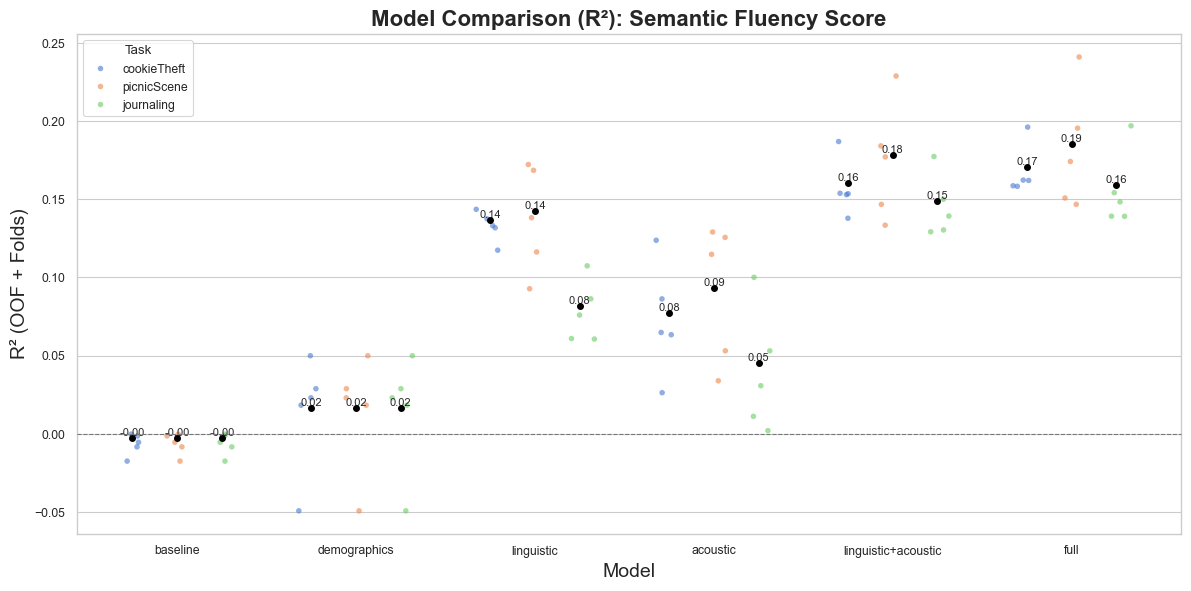

In [10]:
# plots
# plot_model_task_violin(df_folds, metric="r2", target=target, model_to_plot=None, save_path=save_path, model_type_name=model_type_name)
# plot_model_task_pointplot(summary_df, df_folds, save_path=save_path, target=target, model_type_name=model_type_name)
plot_mean_plus_fold_r2(oof_summary, df_folds, save_path=save_path, target=target, model_type_name=model_type_name)


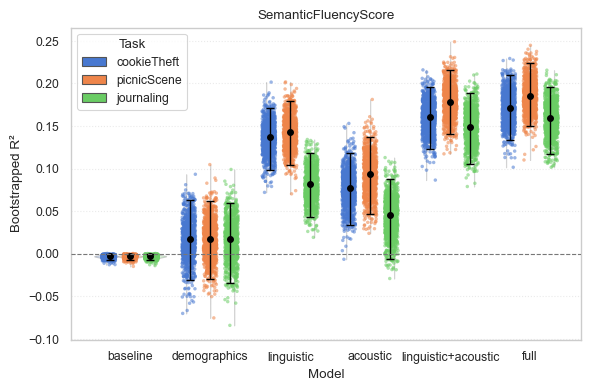

In [11]:
# feature-set/model comparison

subject_set = full_subjects

plot_bootstrap_violin(
    oof_preds=oof_preds,
    target_list=[target], # or all scores if panels
    x="model", hue="task",
    order_x=model_order, order_hue=task_order,
    n_boot=1000, ci=0.95,
    subject_set=subject_set,
    save_path=save_path,
    filename_prefix="model_comparison"
)


KeyError: 'task'

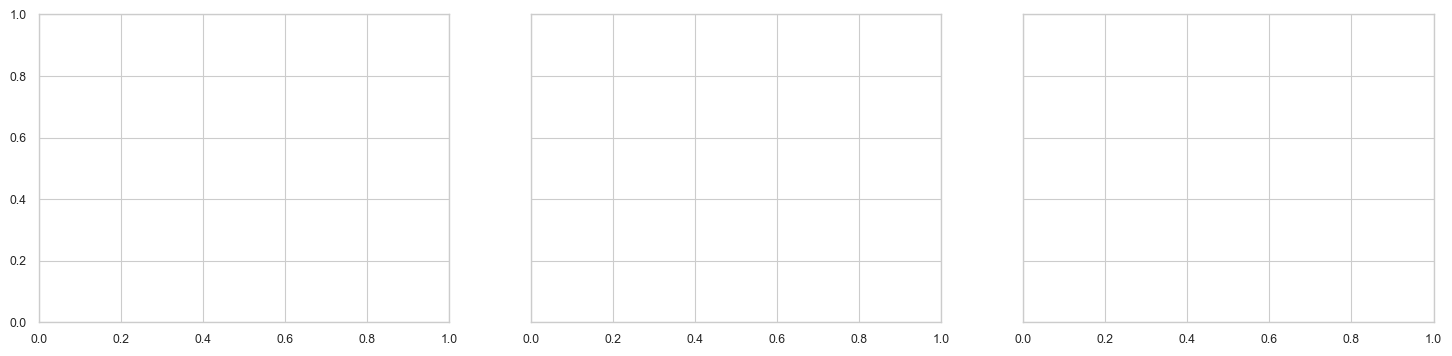

In [12]:
# task comparison

score_cols = ["PictureNamingScore","SemanticFluencyScore","PhonemicFluencyScore"]
# same people across tasks and scores
paired_all = subjects_with_all_features_and_scores(full_subjects, scores_all, score_cols)

plot_bootstrap_violin(
    oof_preds=oof_preds,
    target_list=score_cols,
    x="task", hue="target",
    model="full",
    order_x=task_order, order_hue=score_cols,
    n_boot=1000, ci=0.95,
    subject_set=paired_all,
    save_path=save_path,
    filename_prefix="task_comparison"
)


In [ ]:
# scores comparison

paired_all = subjects_with_all_features_and_scores(full_subjects, scores_all, score_cols)

plot_bootstrap_violin(
    oof_preds=oof_preds,
    target_list=score_cols,
    x="target", hue="task",
    model="full",
    order_x=score_cols, order_hue=task_order,
    n_boot=1000, ci=0.95,
    subject_set=paired_all,
    save_path=save_path,
    filename_prefix="scores_comparison"
)
